### Khang Tran Homework 06 Trees

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

df = pd.read_csv('jamb_exam_results.csv')
df

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,183,20,74,2,10.6,Public,Urban,Yes,No,Low,Low,4996,16,Male,Medium,Primary,2
4996,179,0,80,2,20.0,Public,Rural,No,Yes,Medium,Medium,4997,22,Male,Low,Secondary,1
4997,261,17,89,3,11.3,Public,Urban,No,No,Low,High,4998,18,Male,Medium,Primary,3
4998,183,15,96,2,15.9,Public,Rural,No,No,Low,Medium,4999,18,Male,Medium,Secondary,1


In [103]:
df.dtypes

JAMB_Score                        int64
Study_Hours_Per_Week              int64
Attendance_Rate                   int64
Teacher_Quality                   int64
Distance_To_School              float64
School_Type                      object
School_Location                  object
Extra_Tutorials                  object
Access_To_Learning_Materials     object
Parent_Involvement               object
IT_Knowledge                     object
Student_ID                        int64
Age                               int64
Gender                           object
Socioeconomic_Status             object
Parent_Education_Level           object
Assignments_Completed             int64
dtype: object

### Preparing the dataset:

In [104]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.drop(columns = ['student_id'],axis=1)
df.fillna(0,inplace=True)
X = df.drop('jamb_score',axis=1)
y = df['jamb_score']

X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, test_size =0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=1)

In [105]:
# Convert your DataFrame rows into dictionaries
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')
test_dicts = X_test.to_dict(orient='records')

# Initialize and fit the DictVectorizer
vec = DictVectorizer(sparse=True)

X_train = vec.fit_transform(train_dicts)
X_val = vec.transform(val_dicts)
X_test = vec.transform(test_dicts)

### Q1. Features use for splitting the data:

In [106]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)
split_feature_index = dt.tree_.feature[0]

# Get the feature name from your DictVectorizer
split_feature_name = vec.get_feature_names_out()[split_feature_index]
split_feature_name

'study_hours_per_week'

### Q2. RMSE of validation data:

In [107]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_val = rf.predict(X_val)

print("RMSE of val data: {:.2f}".format(np.sqrt(mean_squared_error(y_val, y_pred_val))))

RMSE of val data: 41.61


### Q3. n_estimators parameter:

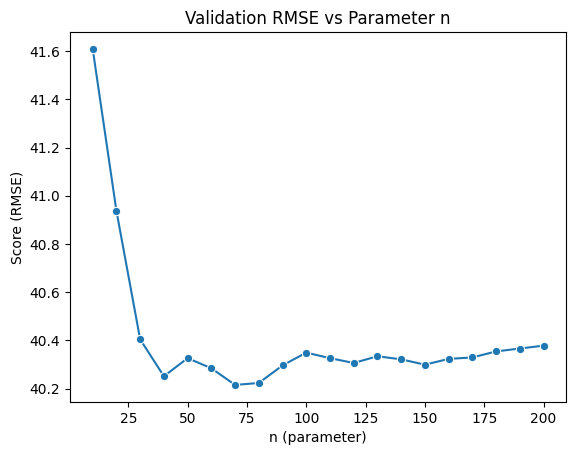

In [108]:
n_list = list(range(10,210,10))
n_score = {}
for n in n_list:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)
    n_score[n] = round(float(np.sqrt(mean_squared_error(y_val, y_pred_val))),3)

# Convert dictionary to lists
x = list(n_score.keys())
y = list(n_score.values())

# Create a line plot
sns.lineplot(x=x, y=y, marker='o')

plt.xlabel("n (parameter)")
plt.ylabel("Score (RMSE)")
plt.title("Validation RMSE vs Parameter n")
plt.show()

### Q4. The best max_depth ?

In [109]:
from alive_progress import alive_bar  # ✅ for progress
# (Assuming X_train, y_train, X_val, y_val already exist)

list_depth = [10, 15, 20, 25]
n_list = list(range(10, 210, 10))

mean_rmse_by_depth = {}
total = len(list_depth) * len(n_list)

print("Running grid search with RandomForestRegressor...\n")

with alive_bar(total, title='Grid Search Progress', bar='smooth', spinner='dots') as bar:
    for depth in list_depth:
        rmses = []
        for n in n_list:
            rf = RandomForestRegressor(
                n_estimators=n,
                max_depth=depth,
                random_state=1,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)
            y_pred_val = rf.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
            rmses.append(rmse)
            bar()  # ✅ update the progress bar
        mean_rmse = np.mean(rmses)
        mean_rmse_by_depth[depth] = mean_rmse

print("\nMean RMSE by max_depth:")
for depth, mean_rmse in mean_rmse_by_depth.items():
    print(f"max_depth={depth}: mean RMSE={mean_rmse:.2f}")

Running grid search with RandomForestRegressor...



Grid Search Progress |████████████████████████████████████████| 80/80 [100%] in 7:58.3 (0.17/s) 

Mean RMSE by max_depth:
max_depth=10: mean RMSE=39.91
max_depth=15: mean RMSE=40.30
max_depth=20: mean RMSE=40.29
max_depth=25: mean RMSE=40.41


Mean RMSE by max_depth:
max_depth=10: mean RMSE=39.91
max_depth=15: mean RMSE=40.30
max_depth=20: mean RMSE=40.29
max_depth=25: mean RMSE=40.41


### Q5. Feature Importance:

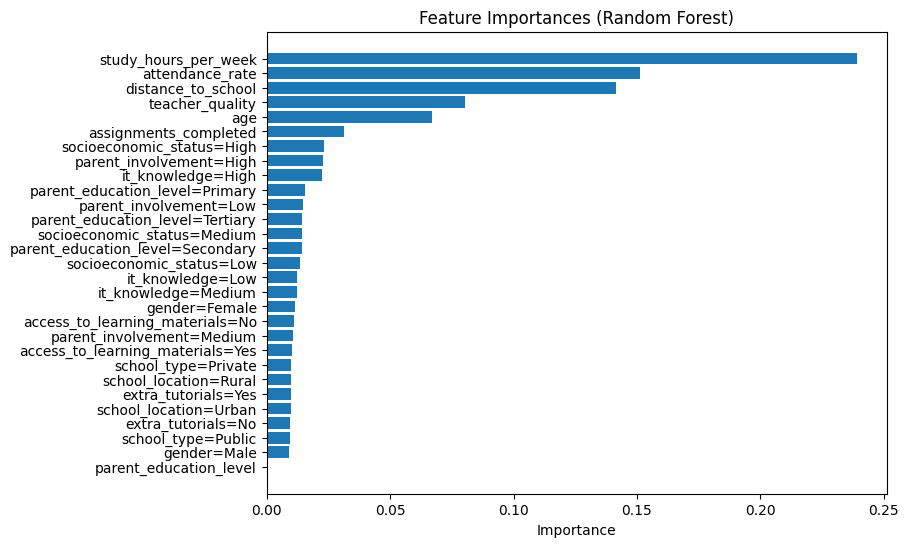

In [110]:
rf_5 = RandomForestRegressor(n_estimators = 10, max_depth=20, random_state = 1, n_jobs=-1)
rf_5.fit(X_train,y_train)
y_pred_val = rf_5.predict(X_val)

# Get feature importances
importances = rf_5.feature_importances_
feature_names = vec.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Plot feature importances
import matplotlib.pyplot as plt
features = [f[0] for f in sorted_features]
importances_sorted = [f[1] for f in sorted_features]
plt.figure(figsize=(8,6))
plt.barh(features, importances_sorted)
plt.xlabel('Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

### Q6. XGBoost: